In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers as layers
from tensorflow.keras import optimizers as optimizers
from tensorflow.keras import callbacks as callbacks

In [2]:
TIME_INTERVAL = 3600
TAGS = ['SPORTS', 'NEWS', 'GAMING', 'FUNNY', 'DOCUMENTARY', 'COOKING', 'SCIENCE']

# Read data

In [3]:
all_data = pd.read_csv('../data/requests_data.csv')

In [4]:
all_data.head()

,endpoint,id,current_time,title,video_time,upload_time,youtuber_username,subscribers,tag,request_count
0,/send,1577833200,1577833200,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,1
1,/watch,1577833200,1577833200,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,94
2,/watch,1577833200,1577833201,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,88
3,/watch,1577833200,1577833202,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,98
4,/watch,1577833200,1577833203,You Won't Believe What This Gdansk Plastic Str...,463,1577833200,Linus Tech Tips,2400,GAMING,89


In [9]:
data_send = all_data[all_data['endpoint'] == '/send'].drop(columns=["endpoint", "request_count", "upload_time", "title", "youtuber_username"])
data_send.set_index("id", inplace=True)
data_send

,current_time,video_time,subscribers,tag
id,,,,
1577833200,1577833200,463,2400,GAMING
1577833500,1577833500,596,2400,GAMING
1577833800,1577833800,94,1200,FUNNY
1577834100,1577834100,691,2400,NEWS
1577834400,1577834400,52,1200,COOKING
...,...,...,...,...
1577918100,1577918100,64,1200,FUNNY
1577918400,1577918400,296,800,NEWS
1577918700,1577918700,1,1200,FUNNY


In [11]:
data_watch = all_data[all_data['endpoint'] == '/watch'].drop(columns=["endpoint", "title", "youtuber_username", "video_time", "tag", "subscribers"])
data_watch

,id,current_time,upload_time,request_count
1,1577833200,1577833200,1577833200,94
2,1577833200,1577833201,1577833200,88
3,1577833200,1577833202,1577833200,98
4,1577833200,1577833203,1577833200,89
5,1577833200,1577833204,1577833200,93
...,...,...,...,...
476309,1577915400,1577919599,1577915400,193
476310,1577917800,1577919599,1577917800,123
476311,1577918700,1577919599,1577918700,0
476312,1577919000,1577919599,1577919000,0


In [43]:
# data_send.join(data_watch, on="movie_id", lsuffix="_L").head()

In [13]:
data_send["tag"].unique()

array(['GAMING', 'FUNNY', 'NEWS', 'COOKING', 'SPORTS', 'DOCUMENTARY',
       'SCIENCE'], dtype=object)

# Prepare dataset

In [14]:
binarizer = LabelBinarizer()
binarizer.fit(TAGS)
binarizer.classes_

array(['COOKING', 'DOCUMENTARY', 'FUNNY', 'GAMING', 'NEWS', 'SCIENCE',
       'SPORTS'], dtype='<U11')

In [15]:
tags_one_hot_encoded = binarizer.transform(data_send.tag)

In [13]:
n_requests_dict = {}

for movie_id in data_send.index:
    movie_requests_data = data_watch[np.logical_and(data_watch['movie_id'] == movie_id, 
                                                    data_watch['current_time'] - data_watch['upload_time'] <= TIME_INTERVAL)]
    n_requests_dict[movie_id] = np.sum(movie_requests_data['request_count'])
    
n_requests_dict[0]

200

In [87]:
feature_names = ['subscribers', 'video_time']

X = np.hstack([data_send[feature_names], tags_one_hot_encoded])
y = np.array(list(n_requests_dict.values()))

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X[:, :2] = X_scaler.fit_transform(X[:, :2])
y = y_scaler.fit_transform(y.reshape(-1, 1))[:, 0]

X.shape, y.shape

((8640, 9), (8640,))

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Random forest

In [96]:
from sklearn.ensemble import RandomForestRegressor

for crit in ["squared_error", "absolute_error", "poisson"][:2]:
    regressor = RandomForestRegressor(criterion=crit)
    regressor.fit(X_train, y_train)
    # print(crit, " - score: ", regressor.score(X_test, y_test))
    print(crit, " - score: ", f'{mean_squared_error(y_test, regressor.predict(X_test)):0.4f}')

    # pd.DataFrame(np.array([regressor.predict(X_test), y_test]).transpose(), columns=["pred", "real"])

squared_error  - score:  0.2359
absolute_error  - score:  0.2461


# Linear regression

In [90]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
print("score: ", regressor.score(X_test, y_test))

pd.DataFrame(np.array([regressor.predict(X_test), y_test]).transpose(), columns=["pred", "real"])

score:  0.7206298901902407


,pred,real
0,-0.099670,0.159673
1,-0.493515,-0.498742
2,1.174622,2.163599
3,4.349182,4.597722
4,-0.550217,-0.611020
...,...,...
1723,-0.171753,-0.253438
1724,-0.099670,-0.163127
1725,-0.247879,-0.623835
1726,0.853226,1.221436


# NN 1

In [113]:
def plot_history(history, ymax=None):
    plt.figure(figsize=(10, 7))
    
    X = np.arange(1, len(history['loss']) + 1)
    
    plt.plot(X, history['loss'], label='train')
    plt.plot(X, history['val_loss'], label='test')
    
    if ymax is not None:
        plt.ylim(0, ymax)

    plt.title(f"val_loss ({history[f'val_loss'][-1]:0.4f})")
    plt.grid()
    plt.legend()
        
    plt.show()

In [114]:
model = tf.keras.Sequential([
    layers.Input(9),
    layers.Dense(1),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(optimizers.Adam(learning_rate=0.01), loss='mse')

history = model.fit(X_train, y_train, batch_size=1024, epochs=100, validation_data=(X_test, y_test)).history

Epoch 1/100
7/7 [==============================] - 0s 14ms/step - loss: 0.6043 - val_loss: 0.4555
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.5315 - val_loss: 0.3952
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4814 - val_loss: 0.3531
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4459 - val_loss: 0.3233
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4218 - val_loss: 0.3023
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4029 - val_loss: 0.2863
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3887 - val_loss: 0.2749
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3789 - val_loss: 0.2666
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3709 - val_loss: 0.2610
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3651 - val_loss: 0.2574
Epoch 11/100
7/7 [==========

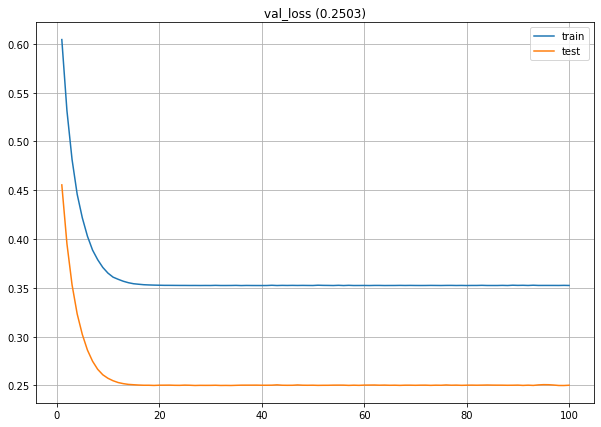

In [116]:
plot_history(history)

# NN 2

In [117]:
model = tf.keras.Sequential([
    layers.Input(9),
    
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    
    layers.Dense(1),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 10)                100       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
 dense_12 (Dense)            (None, 5)                 55        
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [118]:
model.compile(optimizers.Adam(learning_rate=0.01), loss='mse')

history = model.fit(X_train, y_train, batch_size=1024, epochs=100, validation_data=(X_test, y_test)).history

Epoch 1/100
7/7 [==============================] - 0s 17ms/step - loss: 0.9790 - val_loss: 0.7544
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.8006 - val_loss: 0.5677
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.5922 - val_loss: 0.4032
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.4573 - val_loss: 0.3068
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3754 - val_loss: 0.2747
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3561 - val_loss: 0.2624
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3488 - val_loss: 0.2559
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3459 - val_loss: 0.2527
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3417 - val_loss: 0.2524
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3406 - val_loss: 0.2493
Epoch 11/100
7/7 [==========

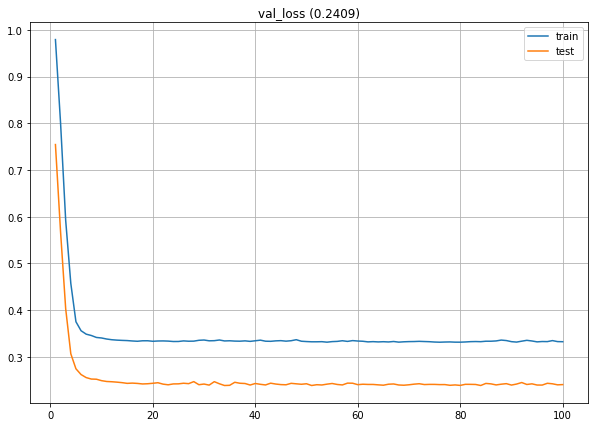

In [119]:
plot_history(history)